In [1]:
# %pip install torch pandas transformers scikit-learn matplotlib nltk pymorphy2 pymorphy2-dicts-uk

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from preprocessing import (get_x, 
                           get_y, 
                           get_vocab_size, 
                           tokenize_x, 
                           balance_data, 
                           create_dictionary, 
                           lemmatize_word, 
                           is_not_punctuation, 
                           get_x1)

In [3]:
# import nltk
# nltk.download('punkt')

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU instead.")

Using GPU: NVIDIA A10G


In [5]:
df = pd.read_csv("translated.csv")
x = get_x(df)
y = get_y(df)
x_titles = get_x1(df)


In [6]:
# import nltk
# nltk.download('punkt')

In [7]:
df_zepopo = balance_data(pd.read_csv("data_set_4.csv"))
print(len(df_zepopo))
x1 = get_x(df_zepopo)
y1 = get_y(df_zepopo)
x1_titles = get_x1(df_zepopo)

Int64Index([ 706, 5325, 1665, 6675, 5605, 2317, 1691, 5030,  318, 3745,
            ...
            6500,  422, 1220, 3439, 3877, 7724, 6732,  102, 2418, 7796],
           dtype='int64', length=2498)
4913


In [8]:
# merging two datasets together
x += x1
y += y1
x_titles += x1_titles

In [9]:
y = torch.tensor(y, dtype=torch.float).view(-1, 1) 

In [10]:
import json
with open("dictionary.json", "r", encoding="utf-8") as f:
    dictionary = json.load(f)

In [11]:
X_train, X_temp, y_train, y_temp, X_titles_train, X_titles_temp = train_test_split(
    x, y, x_titles, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test, X_titles_val, X_titles_test = train_test_split(
    X_temp, y_temp, X_titles_temp, test_size=0.5, random_state=42
)

In [12]:
X_train_tensor, X_val_tensor, X_test_tensor = torch.LongTensor(tokenize_x(X_train, dictionary=dictionary)), torch.LongTensor(tokenize_x(X_val, dictionary=dictionary)), torch.LongTensor(tokenize_x(X_test, dictionary=dictionary)),
X_titles_train_tensor, X_titles_val_tensor, X_titles_test_tensor = torch.LongTensor(tokenize_x(X_titles_train, dictionary=dictionary)), torch.LongTensor(tokenize_x(X_titles_val, dictionary=dictionary)), torch.LongTensor(tokenize_x(X_titles_test, dictionary=dictionary)),  

In [13]:
print(device)

cuda


In [14]:
print(X_test[0], X_test_tensor[0], X_titles_test[0], X_titles_test_tensor[0])

Саміт ЄС закликав Росію припинити всі військові дії проти України, вивести війська, дотримуватися гуманітарних норм tensor([6006, 7944,  469,    0, 7760,    0,  997,    0, 9655,    0, 1261,    0,
        3672,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
    

In [15]:
X_train_tensor.size()

torch.Size([8237, 150])

In [16]:
# making sure the dataset is balanced
print("real news")
print(len([i for i in y if i == 0]))
print("fake news")
print(len([i for i in y if i == 1]))

real news
5895
fake news
5873


In [17]:
X_train_tensor = X_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)

X_titles_train_tensor = X_titles_train_tensor.to(device)
X_titles_val_tensor = X_titles_val_tensor.to(device)
X_titles_test_tensor = X_titles_test_tensor.to(device)

y_train = y_train.to(device)
y_val = y_val.to(device)
y_test = y_test.to(device)


In [18]:
class LSTMClassifier(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 num_layers, 
                 bidirectional, 
                 dropout, 
                 title_weight):
        
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
                            bidirectional=bidirectional, dropout=dropout, batch_first=True)
        self.lstm_title = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
                            bidirectional=bidirectional, dropout=dropout, batch_first=True)
        
        self.title_weight = title_weight
        
        # output layer
        total_hidden_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(total_hidden_dim * 2, output_dim)
        self.act = nn.Sigmoid()

    def forward(self, x, x_titles):
        
        x_embedded = self.embedding(x)
        x1_embedded = self.embedding(x_titles)
        
        _, (hidden_x, _) = self.lstm(x_embedded)
        _, (hidden_x1, _) = self.lstm_title(x1_embedded)

        
        if self.lstm.bidirectional:
            hidden_x = torch.cat((hidden_x[-2,:,:], hidden_x[-1,:,:]), dim=1)
            hidden_x1 = torch.cat((hidden_x1[-2,:,:], hidden_x1[-1,:,:]), dim=1)
        else:
            hidden_x = hidden_x[-1,:,:]
            hidden_x1 = hidden_x1[-1,:,:]
            
        combined_hidden = torch.cat((hidden_x, hidden_x1), dim=1)

        output = self.fc(combined_hidden)
        return self.act(output)

In [19]:
vocab_size = get_vocab_size(df)
print(vocab_size)
embedding_dim = len(X_train_tensor[0])
print(embedding_dim)
output_dim = 1
hidden_dim = 16
num_layers = 1
learning_rate=0.0005
dropout = 0.5
num_epochs = 1000
bidirectional = True

133652
150


In [20]:
model = LSTMClassifier(vocab_size=vocab_size,
                       embedding_dim=embedding_dim, 
                       hidden_dim=hidden_dim, 
                       output_dim=output_dim, 
                       num_layers=num_layers,
                       bidirectional=bidirectional, 
                       dropout=dropout,
                       title_weight=0.5)
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [21]:
from sklearn.metrics import accuracy_score

In [22]:
import numpy as np

best_loss = float('inf')
best_epoch = 0
accuracies_train = []
accuracies_val = []
losses_train = []
losses_val = []

patience = 30
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor, X_titles_train_tensor)
    
    # loss
    loss = criterion(outputs, y_train)
    losses_train.append(loss.item())  # Logging the loss value
    loss.backward()
    optimizer.step()

    # accuracy (need to move tensors to CPU before converting to NumPy)
    with torch.no_grad():
        predicted = (outputs >= 0.5).squeeze().long()
        accuracy = accuracy_score(y_train.cpu().numpy(), predicted.cpu().numpy())
        accuracies_train.append(accuracy)
    
    # validation
    model.eval()
    val_outputs = model(X_val_tensor, X_titles_val_tensor)

    # val loss
    val_loss = criterion(val_outputs, y_val)
    losses_val.append(val_loss.item())  # Logging the validation loss value

    # val accuracy (move to CPU and convert to NumPy)
    with torch.no_grad():
        predicted_val = (val_outputs >= 0.5).squeeze().long()
        accuracy_val = accuracy_score(y_val.cpu().numpy(), predicted_val.cpu().numpy())
        accuracies_val.append(accuracy_val)
    
    if val_loss < best_loss:
        best_loss = val_loss
        best_epoch = epoch
        best_weights = model.state_dict()
        patience_counter = 0  # Reset patience counter on improvement
    else:
        patience_counter += 1
    
    print(f"Epoch: {epoch+1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

    if patience_counter >= patience:
        print("Early stopping triggered")
        break
    
print("Best epoch: ", best_epoch)


Epoch: 1/1000, Training Loss: 0.6932816505432129, Validation Loss: 0.6939173340797424
Epoch: 2/1000, Training Loss: 0.6922736167907715, Validation Loss: 0.6931660175323486
Epoch: 3/1000, Training Loss: 0.6912693381309509, Validation Loss: 0.6924208402633667
Epoch: 4/1000, Training Loss: 0.6902701258659363, Validation Loss: 0.6916778087615967
Epoch: 5/1000, Training Loss: 0.6892739534378052, Validation Loss: 0.6909400820732117
Epoch: 6/1000, Training Loss: 0.6882835626602173, Validation Loss: 0.6902005672454834
Epoch: 7/1000, Training Loss: 0.687292754650116, Validation Loss: 0.6894679069519043
Epoch: 8/1000, Training Loss: 0.686309278011322, Validation Loss: 0.6887332201004028
Epoch: 9/1000, Training Loss: 0.6853253245353699, Validation Loss: 0.6880037784576416
Epoch: 10/1000, Training Loss: 0.6843461990356445, Validation Loss: 0.6872764229774475
Epoch: 11/1000, Training Loss: 0.6833680868148804, Validation Loss: 0.6865498423576355
Epoch: 12/1000, Training Loss: 0.6823927164077759, Val

Epoch: 97/1000, Training Loss: 0.5364094972610474, Validation Loss: 0.5899657607078552
Epoch: 98/1000, Training Loss: 0.5336169004440308, Validation Loss: 0.5883076786994934
Epoch: 99/1000, Training Loss: 0.5308073163032532, Validation Loss: 0.5866480469703674
Epoch: 100/1000, Training Loss: 0.5279756784439087, Validation Loss: 0.5849952697753906
Epoch: 101/1000, Training Loss: 0.5251269936561584, Validation Loss: 0.5833498239517212
Epoch: 102/1000, Training Loss: 0.5222606658935547, Validation Loss: 0.5817040801048279
Epoch: 103/1000, Training Loss: 0.5193763971328735, Validation Loss: 0.5800572633743286
Epoch: 104/1000, Training Loss: 0.5164763927459717, Validation Loss: 0.5784031748771667
Epoch: 105/1000, Training Loss: 0.5135600566864014, Validation Loss: 0.5767415761947632
Epoch: 106/1000, Training Loss: 0.5106282234191895, Validation Loss: 0.5750701427459717
Epoch: 107/1000, Training Loss: 0.5076810717582703, Validation Loss: 0.5733897686004639
Epoch: 108/1000, Training Loss: 0.5

Epoch: 191/1000, Training Loss: 0.2246902585029602, Validation Loss: 0.4575800597667694
Epoch: 192/1000, Training Loss: 0.22193977236747742, Validation Loss: 0.45698681473731995
Epoch: 193/1000, Training Loss: 0.21921147406101227, Validation Loss: 0.4563462734222412
Epoch: 194/1000, Training Loss: 0.216499462723732, Validation Loss: 0.4556772708892822
Epoch: 195/1000, Training Loss: 0.213811993598938, Validation Loss: 0.4550052881240845
Epoch: 196/1000, Training Loss: 0.21115350723266602, Validation Loss: 0.45436033606529236
Epoch: 197/1000, Training Loss: 0.20852495729923248, Validation Loss: 0.45376428961753845
Epoch: 198/1000, Training Loss: 0.20592190325260162, Validation Loss: 0.4532112181186676
Epoch: 199/1000, Training Loss: 0.20334427058696747, Validation Loss: 0.45272767543792725
Epoch: 200/1000, Training Loss: 0.200787752866745, Validation Loss: 0.45230385661125183
Epoch: 201/1000, Training Loss: 0.198250874876976, Validation Loss: 0.45192575454711914
Epoch: 202/1000, Trainin

In [23]:
if best_weights is not None:
    model.load_state_dict(best_weights)

In [24]:
print(accuracies_train[best_epoch],
accuracies_val[best_epoch],
losses_train[best_epoch],
losses_val[best_epoch])

0.9749908947432318 0.7864022662889518 0.13736218214035034 0.4402501583099365


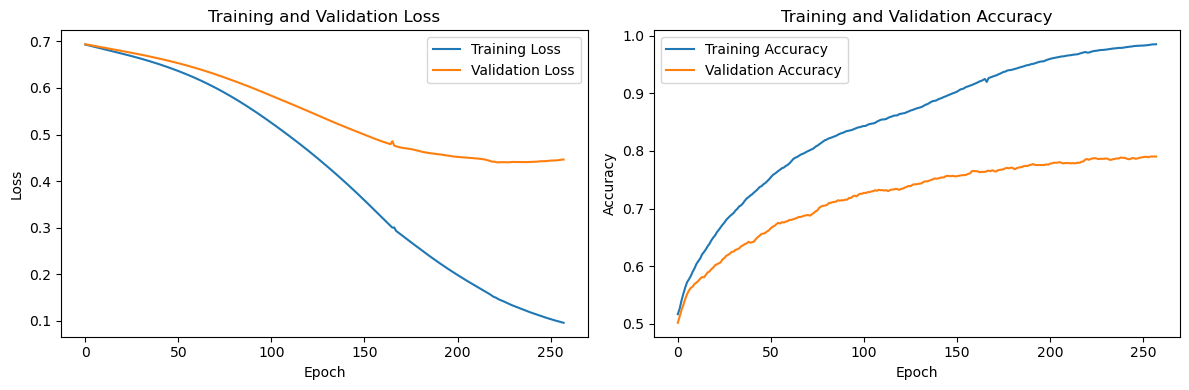

In [25]:
# lists to tensors
losses_train = torch.tensor(losses_train)
losses_val = torch.tensor(losses_val)
accuracies_train = torch.tensor(accuracies_train)
accuracies_val = torch.tensor(accuracies_val)

# training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(losses_train.detach().numpy(), label='Training Loss')
plt.plot(losses_val.detach().numpy(), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(accuracies_train.detach().numpy(), label='Training Accuracy')
plt.plot(accuracies_val.detach().numpy(), label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
from sklearn.metrics import (precision_score, recall_score, f1_score)

In [27]:
test_outputs = model(X_test_tensor, X_titles_test_tensor)
test_outputs = (test_outputs >= 0.5).squeeze().long()

In [28]:
test_outputs = test_outputs.cpu().numpy()
y_test = y_test.cpu().numpy()

In [29]:
test_accuracy = accuracy_score(y_test, test_outputs)
test_precision = precision_score(y_test, test_outputs)
test_recall = recall_score(y_test, test_outputs)
test_f1 = f1_score(y_test, test_outputs)

In [30]:
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("f1:", test_f1)

Accuracy: 0.804643261608154
Precision: 0.7931404072883173
Recall: 0.8295964125560538
f1: 0.810958904109589


test dataset (40 texts)

In [38]:
import json
with open("test_set.json", "r", encoding="utf-8") as f: 
    test_texts = json.load(f)

fake_texts = [t["text"] for t in test_texts if t["label"] == "Fake"]
fake_titles = [t["title"] for t in test_texts if t["label"] == "Fake"]
real_texts = [t["text"] for t in test_texts if t["label"] == "Real"]
real_titles = [t["text"] for t in test_texts if t["label"] == "Real"]

In [39]:
print(len(fake_texts), len(real_texts))

20 20


In [40]:
df = pd.DataFrame(columns = ["ukr_text", "label", "title_ukr"])
for i, text in enumerate(fake_texts): 
    df.loc[i] = {
        "ukr_text": text, 
        "label": "Fake", 
        "title_ukr": fake_titles[i]
    }

for i, text in enumerate(real_texts): 
    df.loc[i+20] = {
        "ukr_text": text, 
        "label": "Real", 
        "title_ukr": real_titles[i]
    }

In [41]:
# df

In [42]:
len(df)

40

In [43]:
test_data_x = torch.LongTensor(tokenize_x(get_x(df), dictionary=dictionary))
test_data_x_titles = torch.LongTensor(tokenize_x(get_x1(df), dictionary=dictionary))
test_data_y = torch.tensor(get_y(df), dtype=torch.float).view(-1, 1).cpu()

In [44]:
test_data_x = test_data_x.to(device)
test_data_x_titles = test_data_x_titles.to(device)
# test_data_y = test_data_x.cpu()

In [45]:
test_outputs = model(test_data_x, test_data_x_titles)
test_outputs = (test_outputs >= 0.5).squeeze().long()

In [46]:
test_outputs

tensor([0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [47]:
test_outputs = test_outputs.cpu().numpy()
test_data_y = test_data_y.cpu().numpy()

In [48]:
test_accuracy = accuracy_score(test_data_y, test_outputs)
test_precision = precision_score(test_data_y, test_outputs)
test_recall = recall_score(test_data_y, test_outputs)
test_f1 = f1_score(test_data_y, test_outputs)

In [49]:
print(test_accuracy, test_precision, test_recall, test_f1)

0.8 0.8 0.8 0.8


In [52]:
model.to("cpu")
model_scripted = torch.jit.script(model)
model_scripted.save('model_scripted.pt')
# torch.save(model, 'lstm_with_zepopo_32_without_markers_with_titles.pth')